## Reinforcement Learning

Рекомендованная литература:

* Barto Sutton Reinforcement Learning: An Introduction (классика теории)
* Lapan Deep Reinforcement Learning Hands-On Second Edition (Книга с большим количеством примеров по RL)
* Sudharsan Ravichandiran Hands-On Reinforcement Learning with Python (Тоже много примеров)

Прочая дополнительная литература:

* Alex Zai and Brandon Brown Deep Reinforcement Learning in Action


Полезные ссылки:
* https://www.alexirpan.com/2018/02/14/rl-hard.html Deep Reinforcement Learning Doesn't Work Yet
* https://openai.com/blog/faulty-reward-functions/  Faulty Reward Functions in the Wild

In [2]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
        
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/atari_wrappers.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/utils.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/replay_buffer.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/framebuffer.py

    !pip install gym[box2d]

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'


import random
import numpy as np
import torch
import utils

ModuleNotFoundError: No module named 'utils'

In [8]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn

## Intro



### Обучение с учителем
Если у нас есть набор примеров с правильными ответами, то мы используем эту выборку для обучения нашей модели, а после обучения, применяем её к неразмеченным данным. Именно этот подход мы использовали, когда обучали классификатор для MNIST, подавая на вход сети картинки с изображениями рукописных цифр и считая градиент для подстройки весов на основе разницы между известным лэйблом цифры и выходом нейросети.
### Обучение без учителя
В некоторых случаях у нас нет размеченных данных, на которых мы могли бы заранее обучить модель. Но, при решении некоторых задач, можно обойтись без размеченной выборки. Примером такой задачи является задача кластеризации.
### Обучение с подкреплением
В некоторых случаях существующие методы обучения без учителя нам не подходят. В то же время у нас нет возможности создать качественную обучающую выборку. При этом мы можем постфактум оценить действия нашей модели и использовать эту оценку подстроить модель так, чтобы она чаще совершала желательные действия и реже - нежелательные. В литературе такую оценку называют вознаграждением (reward), а обучение строится таким образом, чтобы это модель стремилась максимизировать получаемое вознаграждение.

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-1-7.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-1-17.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

## Терминология: агент, функция награды, состояние среды

Агент и среда - ключевые понятия в обучении с подкрелением.

**Агент** - программа, принимающая решение о дальнейших действиях на основе информации о состоянии среды.

**Среда** - это мир, в котором агент должен "выживать", т.е. всё, с чем агент может прямо или косвенно взаимодействовать. Среда обладает состоянием (State), агент может влиять на среду, совершая какие-то действия (Actions), переводя среду при этом из одного состояния в другое и получая какое-то вознаграждение. Среда описывается пространством возможных состояний. Конкретное состояние - вектор в этом пространстве.

В зависимости от конкретной задачи, агент может наблюдать либо полное состояние среды, либо только некоторую его часть. Во втором случае, агенту может потребоваться какое-то внутреннее представление полного состояния, которое будет обновляться по мере получения новых данных.

**Фукнция награды** - вводимая программистом формула вычисления ценности действия на основе финального результата, ожидания этого результата, промежуточных результатов и любых других параметров, которые будут подсказывать путь к наилучшей последовательности действий агента. Это некоторый аналог функции потерь, без которой непонятно чему учиться. Например, в шахматах истинная награда это победа, но взятая фигура соперника тоже ценна и должна увеличивать награду, если мы хотим подсказать агенту, что брать чужие фигуры полезно. Может ли после этого агент получать мат, позарившись на незащищенную фигуру? Да, ровно как и неопытный шахматный игрок. Попытка передать через дополнительные неосновные награды подсказки к получению основной награды называется **reward shaping**.

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-1-8.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-1-9.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

### MDP

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-24_.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-4.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-3.png" alt="Drawing" style="width: 500px;"/> </td>
    <td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-25_.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>


<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-12.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-13.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>


<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-2-15.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-2-17.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-26.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-28.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-29_.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-30.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-31.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-33_.png" alt="Drawing" style="width: 500px;"/> </td>
    <td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-35__.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>


<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-32_.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-34_.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-36.png" alt="Drawing" style="width: 500px;"/>

Если все записать в матричной форме, то можно увидеть, что Bellman Expectaion Equation имеет решение (что нельзя сказать о поиске оптимальной политике, как мы увидим ниже)

### Давайте теперь искать наилучшую политику или наилучший способ поведения

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-37.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-38_.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-39_.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-40.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-41.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-42_.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-43.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-45_.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-44_.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-46_.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-47_.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-48.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-2-49.png" alt="Drawing" style="width: 500px;"/>

## Bellman

### Policy evaluation

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-2-56.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-2-67.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-3-9.png" alt="Drawing" style="width: 500px;"/>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-3-10.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-3-11.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

### Policy improvement

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-2-60.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/silver-3-13.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-2-72.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-2-75.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

## Библиотека OpenAI Gym

В OpenAI создали готовую библиотеку для моделировавния, визуализирования и обучения, что не только удобно для тестов. Одно из хороших преимуществ это качественный абстрактный интерфейс взаимодействия среды и агента, который позволяет делать совместимые с Gym среды и впоследствии интегрироваться в экосистему, легко подменять типы агентов, тестировать, сравнивать.
Среди готовых сред для взаимодействия с ними есть
- игры Atari - полноценные компьютерные игры, типа Арканоида, где вместо человека в компьютер играет агент.
- классические настольные пошаговые игры: шахматы, go.
- физические симуляции, где нужно управлять физическим объектом: маятник, который должен перевернуться и балансировать за счёт раскачивания; тележка, которая должна проехать через холм за счёт раскачивания.
- и т.д.### State-value function

### Пример окружения Gym
В этом примере загружается готовая среда: машинка должна заехать на горку. Функция награды встроенная. А агент - случайное воздействие. Оно ничему не учится, лишь хаотически выдаёт действия, но это показывает где взять все необходимые данные для обучения.

In [ ]:
import gym
env = gym.make("MountainCar-v0")
MAX_NUM_EPISODES = 5

for episode in range(MAX_NUM_EPISODES):
    done = False
    obs = env.reset()
    total_reward = 0.0 # To keep track of the total reward obtained in each episode
    step = 0
    while not done:
        env.render()
        
        
        
        action = env.action_space.sample()  # Sample random action.
                                            # This will be replaced
                                            # by our agent's action
                                            # when we # start
                                            # developing the agent algorithms
        
        
        next_state, reward, done, info = \
        env.step(action)  # Send the action to the
                          # environment and receive       
                          # the next_state, reward and
                          # whether done or not
        total_reward += reward
        step += 1
        obs = next_state
    print("\n Episode #{} ended in {} steps. total_reward={}".format(episode, step+1,
total_reward))
env.close()

## Temporal-Difference Learning

### Q-learning

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-14.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-16.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-19.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-20.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-24.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-25.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-27.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-28.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-31.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-32.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-33.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-34.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-36.png" alt="Drawing" style="width: 500px;"/> 


<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-37.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-39.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-40.png" alt="Drawing" style="width: 430px;"/> 


<img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-44.png" alt="Drawing" /> 

<img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-48.png" alt="Drawing" /> 

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-50.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-52.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-53.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-54.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-59.png" alt="Drawing" style="width: 450px;"/> 

## Аппроксимация Q-функции (Q-таблицы)

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-6.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-8.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-9.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-10.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-11.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-12.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/coursera-4-24.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/coursera-4-25.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-14.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-15.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-16.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-17.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

## Experience replay

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-18.png" alt="Drawing" /> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-3-62.png" alt="Drawing" /> </td>
</tr></table>

В большинстве окружений информация, получаемая агентом распределена не независимо. Т.е. последовательные наблюдения агента сильно коррелированы между собой (что понятно из интуитивных соображений, т.к. большинство окружений, в которых применяется RL, предполагают, что все изменения в них последовательны). Корреляция примеров ухудшает сходимость стохастического градиентного спуска. Таким образом нам нужен способ, который позволяет улучшить распределение примеров для обучения (устранить или снизить корреляцию между ними). Обычно используется метод **проигрывания опыта (experience replay)**. Суть этого метода в том, что мы сохраняем некоторое количество примеров (состояние, действия, вознаграждение) в специальном буфере и для обучения выбираем случайные мини-батчи из этого буфера.

Так же **experience replay** позволяет агенту эффективнее использовать свой прошлый опыт.

<img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-23.png" alt="Drawing" style="width: 500px;"/> 

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-24.png" alt="Drawing" /> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-25.png" alt="Drawing" /> </td>
</tr></table>

<img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-26.png" alt="Drawing" /> 

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-28.png" alt="Drawing" /> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-29.png" alt="Drawing" /> </td>
</tr></table>

## Пример c CartPole

Another env can be used without any modification of the code. State space should be a single vector, actions should be discrete.

CartPole is the simplest one. It should take several minutes to solve it.

For LunarLander it can take 1-2 hours to get 200 points (a good score) on Colab and training progress does not look informative.

In [5]:
ENV_NAME = 'CartPole-v1'

def make_env(seed=None):
    # some envs are wrapped with a time limit wrapper by default
    env = gym.make(ENV_NAME).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

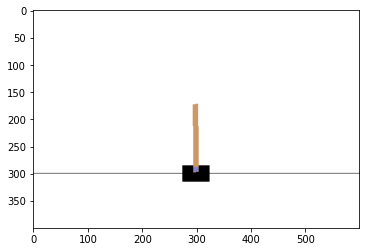

In [9]:
env = make_env()
env.reset()
plt.imshow(env.render("rgb_array"))
state_shape, n_actions = env.observation_space.shape, env.action_space.n

### Building a network

We now need to build a neural network that can map observations to state q-values.
The model does not have to be huge yet. 1-2 hidden layers with < 200 neurons and ReLU activation will probably be enough. Batch normalization and dropout can spoil everything here.

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# those who have a GPU but feel unfair to use it can uncomment:
# device = torch.device('cpu')
device
print(state_shape)

(4,)


In [1]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        # Define your network body here. Please make sure agent is fully contained here
        assert len(state_shape) == 1
        state_dim = state_shape[0]
        
        
        # Define NN
        ##############################################
        hidden_size = 150
        self._nn = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions),
            nn.ReLU()
        )
        ##############################################

        
    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch states, shape = [batch_size, *state_dim=4]
        """
        # Use your network to compute qvalues for given state
        
        ##############################################
        qvalues = self._nn(state_t)
        ##############################################

        assert qvalues.requires_grad, "qvalues must be a torch tensor with grad"
        assert (
            len(qvalues.shape) == 2 and 
            qvalues.shape[0] == state_t.shape[0] and 
            qvalues.shape[1] == n_actions
        )

        return qvalues

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

NameError: name 'nn' is not defined

In [13]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

### Experience Replay Buffer and Target Networks

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [2]:
from replay_buffer import ReplayBuffer

exp_replay = ReplayBuffer(2000)


target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

ModuleNotFoundError: No module named 'replay_buffer'

### TD-Loss

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes Q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

In [3]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    """ Compute td loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float32)    # shape: [batch_size, *state_shape]
    actions = torch.tensor(actions, device=device, dtype=torch.int64)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float32)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float32,
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)  # shape: [batch_size, n_actions]

    # compute q-values for all actions in next states
    # with torch.no_grad():
    predicted_next_qvalues = target_network(next_states)  # shape: [batch_size, n_actions]
    
    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]  # shape: [batch_size]

    # compute V*(next_states) using predicted next q-values
    ##############################################
    next_state_values = predicted_next_qvalues.max(axis=-1)[0]
    ##############################################

    assert next_state_values.dim() == 1 and next_state_values.shape[0] == states.shape[0], \
        "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    ###############################################
    target_qvalues_for_actions = rewards + gamma * next_state_values * is_not_done
    ##############################################

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim() == 2, \
            "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim() == 1, \
            "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim() == 1, \
            "there's something wrong with target q-values, they must be a vector"

    return loss

NameError: name 'device' is not defined

### Main loop

In [7]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time

In [6]:
# your favourite random seed
seed = 2
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

env = make_env(seed)
state_dim = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

agent = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())

NameError: name 'random' is not defined

In [5]:
REPLAY_BUFFER_SIZE = 10**4

exp_replay = ReplayBuffer(REPLAY_BUFFER_SIZE)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available. 
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """
             )
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == REPLAY_BUFFER_SIZE:
        break
print(len(exp_replay))

NameError: name 'ReplayBuffer' is not defined

In [8]:
timesteps_per_epoch = 1
batch_size = 32
total_steps = 4 * 10**4
decay_steps = 1 * 10**4

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

max_grad_norm = 5000

mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []
step = 0

def wait_for_keyboard_interrupt():
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        pass

NameError: name 'torch' is not defined

In [9]:
state = env.reset()
with trange(step, total_steps + 1) as progress_bar:
    for step in progress_bar:
        if not utils.is_enough_ram():
            print('less that 100 Mb RAM available, freezing')
            print('make sure everything is ok and use KeyboardInterrupt to continue')
            wait_for_keyboard_interrupt()

        agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

        # play
        _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

        # train
        # <YOUR CODE: sample batch_size of data from experience replay>
        s,a,r,next_s, is_done = exp_replay.sample(batch_size)
        # loss = <YOUR CODE: compute TD loss>
        loss = compute_td_loss(s, a, r, next_s, is_done, agent, target_network)

        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
        opt.step()
        opt.zero_grad()

        if step % loss_freq == 0:
            td_loss_history.append(loss.data.cpu().item())
            grad_norm_history.append(grad_norm)

        if step % refresh_target_network_freq == 0:
            # Load agent weights into target_network
            # <YOUR CODE>
            target_network.load_state_dict(agent.state_dict())

        if step % eval_freq == 0:
            mean_rw_history.append(evaluate(
                make_env(seed=step), agent, n_games=3, greedy=True, t_max=1000)
            )
            initial_state_q_values = agent.get_qvalues(
                [make_env(seed=step).reset()]
            )
            initial_state_v_history.append(np.max(initial_state_q_values))

            clear_output(True)
            print("buffer size = %i, epsilon = %.5f" %
                (len(exp_replay), agent.epsilon))

            plt.figure(figsize=[16, 9])

            plt.subplot(2, 2, 1)
            plt.title("Mean reward per episode")
            plt.plot(mean_rw_history)
            plt.grid()

            assert not np.isnan(td_loss_history[-1])
            plt.subplot(2, 2, 2)
            plt.title("TD loss history (smoothened)")
            plt.plot(utils.smoothen(td_loss_history))
            plt.grid()

            plt.subplot(2, 2, 3)
            plt.title("Initial state V")
            plt.plot(initial_state_v_history)
            plt.grid()

            plt.subplot(2, 2, 4)
            plt.title("Grad norm history (smoothened)")
            plt.plot(utils.smoothen(grad_norm_history))
            plt.grid()

            plt.show()

NameError: name 'env' is not defined

## Дальнейшие идеи для улучшения

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-30.png" alt="Drawing" /> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-31.png" alt="Drawing" /> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-32.png" alt="Drawing" /> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-33.png" alt="Drawing" /> </td>
</tr></table>

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-34.png" alt="Drawing" /> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-35.png" alt="Drawing" /> </td>
</tr></table>

## Double DQN


<img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-36.png" alt="Drawing" style="width: 500px;"/> 

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-37.png" alt="Drawing" /> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-38.png" alt="Drawing" /> </td>
</tr></table>

Одной из проблем Q-Networks является неустойчивость. Часто разность ожидаемых вознаграждений для различных действий близка и поскольку выбор действия производится с помощью argmax, то выброс в данных может привести к тому, что выбираемое действие изменится. Для того, чтобы повысить стабильность используется техника **Target Q-Network**. Суть в том, что мы замораживаем веса нашей сети на фиксированное число шагов и затем используем её для вычисления функции ошибки и обучения второй сети. Периодически копируем из веса рабочей сети в Target Q-Network.
В следующем примере мы будем делать это каждый эпизод.

<img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-39.png" alt="Drawing" style="width: 500px;"/> 

<table><tr>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-48.png" alt="Drawing" /> </td>
<td> <img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-49.png" alt="Drawing" /> </td>
</tr></table>

<img src="https://edunet.kea.su/repo/src/L15_RL/img/yds-4-50.png" alt="Drawing" style="width: 500px;"/> 

# Другие улучшения DQN

## Prioritized Experience Replay

Минибатчи из памяти выбираются не с равномерным распределением, а добавляем туда больше примеров, в которых предсказанные значения Q сильнее всего отличаются от корректных. Т.е. примеры с максимальным **TD error** получают максимальный приоритет.

## Dueling networks

Основная идея в том, что мы разделяем нашу сеть на две головы, одна из которых предсказывает абсолютное значение состояния \\( V(S) \\), а вторая - относительное преимущество одний действий над другими \\( A(s, a) = Q(s, a) - V(s) \\). Это преимущество называется advantage. Далее из этих двух значений мы собираем нашу Q-функцию, как \\( Q(s,a) = V(s) + A(a) \\)


## Multi-step learning/n-step learning

Основная идея в том, чтобы считать функцию ценности не по двум соседним примерам, а сразу по n. Это позволяет сети лучше запоминать длинные последовательности действий.

## Distributional RL

Детерминированное значение Q заменяется случайным распределением Z с некоторыми параметрами, которые определяются в ходе обучения.

# Rainbow

Rainbow - набор перечисленных выше твиков. 

# R2D2

Использование RNN сетей для experience replay

## Резюме по типам алгоритмов RL

### Model-free / Model-based
Model-free не строит модель окружения или функции награды. Это проще. Model-based алгоритм пытается предсказывать, каким будет следующее состояние окружения или вознаграждение. Это позволяет мыслить на несколько шагов вперёд. Например, совершенно не больно прыгать с крыши. Больно потом, когда разбиваешься о землю. Модель среды и награды позволяет принимать решения не прыгать с крыши, хотя и model-free подход позволяет это понять, хоть и более сложно и грубо.
### Value-based / policy-based
Policy-based  методы оптимизируют напрямую функцию принятия решения агента. Стратегия (policy) обычно представлена распределением вероятности доступных действий. Value-based метод оптимизирует оценку вознаграждения для всех действий и выбирает выбирает то действие, по которому прогнозируется большее значение. Методы, основанные на Policy Gradients лучше работают при большой размерности пространства действий, а Value-based методы, такие, как Deep Q-Learning требуют меньшего количества повторений для сходимости при малой размерности.
### On-Policy / Off-Policy
Off-policy подход позволяет учиться на исторических данных или на записанных заранее действиях человека. On-policy - только на собственных действиях агента. Это довольно важное деление, так как обучение на собственных действиях просто недоступно для многих задач. Плохо ли автомобилю с автопилотом въехать в стену? Надо попробовать, так будет работать on-policy метод. А лучше взять понимание, что это плохо из готовых данных, синтетических, например и усвоить этот опыт. Даже если мы используем симуляцию среды, а не реальную среду, то количество эпизодов симуляции обычно порядка сотен тысяч и их симуляция съедает много времени. Каждый раз проходить переобучение с нуля очень неудобно, а возможность импортировать накопленный опыт симуляции среды сильно экономит ресурсы. Однако off-policy методы можно применить не всегда.
### Deterministic Policy / Stochastic Policy
В зависимости от среды, наша стратегия может быть либо детерминированной - выбираем сразу определённое действие с помощью argmax, либо стохастической, когда мы окончательное решение принимается с помощью генератора случайных чисел на основе распределения вероятности, выданного сетью.

### SARSA

## DQN

## C51
## Monte-Carlo Tree Search
Silver L8